# Ideal Parameter Analysis ($\delta=2.25$, $\tau=0.95$, $\alpha=2$) ($\tau$ low)

In [1]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import sys

from datetime import datetime

sys.path.append('../../feeg_fmri_sync')

from feeg_fmri_sync.plotting import (
    plot_all_search_results_2d,
    plot_local_minima
)
from feeg_fmri_sync.search import (
    build_models,
    search_voxels
)
from feeg_fmri_sync.simulations import (
    build_model_to_fmri,
    generate_downsampled_simulated_fmri,
)
from feeg_fmri_sync.utils import (
    generate_descriptions_from_search_df,
)
from feeg_fmri_sync.vectorized_models import VectorizedHemodynamicModel

In [2]:
try_to_reuse = True
submit_to_cluster = False

## Initialize constants for Hemodynamic Modeling

In [3]:
### Initialize constants ###
sample_freq = 20
tr = 800
n_trs_skipped_at_beginning = 0
hemodynamic_response_window = 30

# Actual Values to generate data from
expected_delta = 2.25
expected_tau = 0.95
expected_alpha = 2

## Initialize constants for simulation

In [4]:
# Plot the generated data
# NOTE: only the first of the trials will be plotted
plot_generated_data = True

# Plot perfect data when modeling
plot_perfect_comparison = True

# noises to examine and plot when modeling
noise_range = range(1, 11)  
noises_to_plot = [3, 5, 10]

# trials we run for each condition and how many trials to plot when modeling
num_trials = 100  
num_trials_to_plot = 1

# models to examine
models_to_test = [
    {
        'name': 'downsample',
        'model': VectorizedHemodynamicModel,
        'fmri_data_generator': generate_downsampled_simulated_fmri,
    }
]

# eeg data types to use
eeg_data_options_for_fmri_generation = ['without_nans']
eeg_data_options_for_simulation = ['without_nans', 'with_nans']

## Display Generated Noise against Simulated Ground Truth

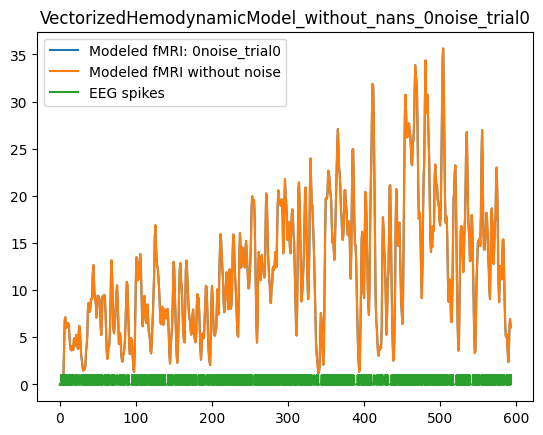

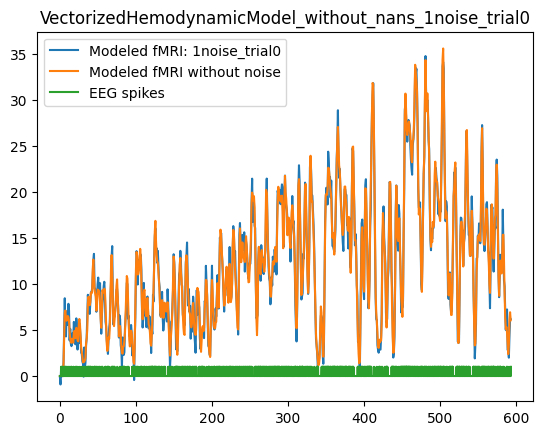

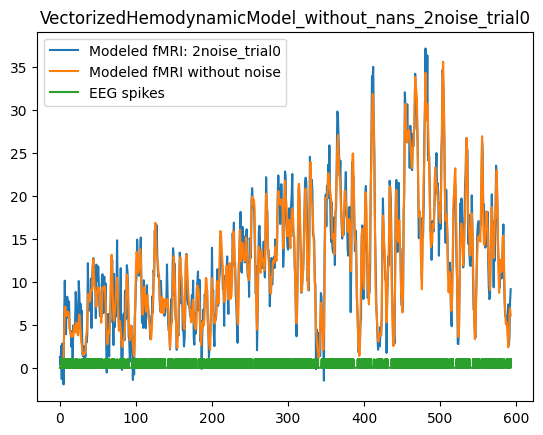

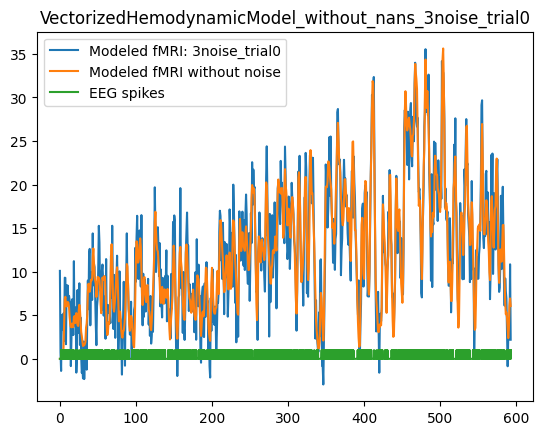

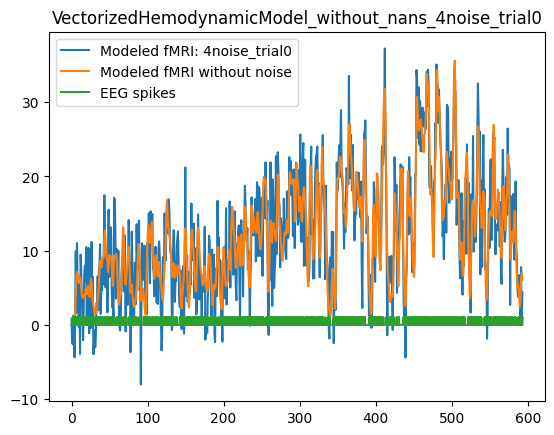

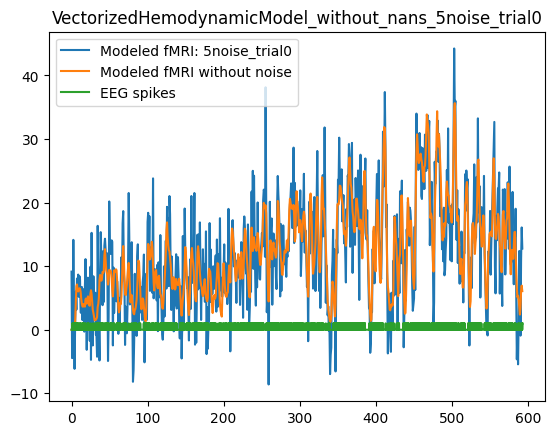

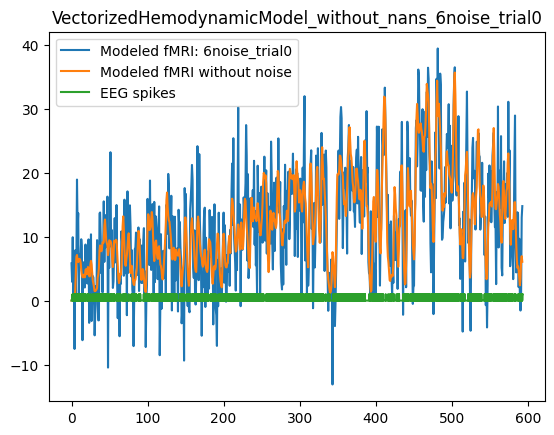

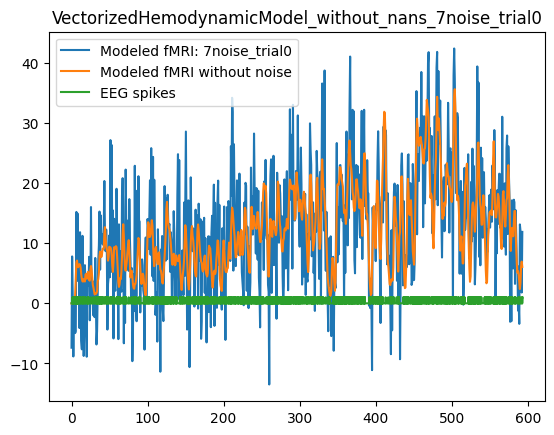

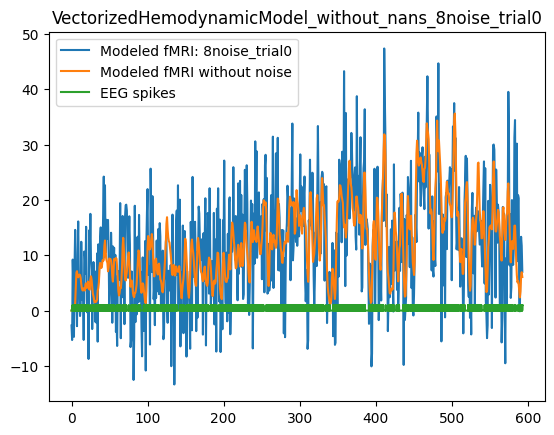

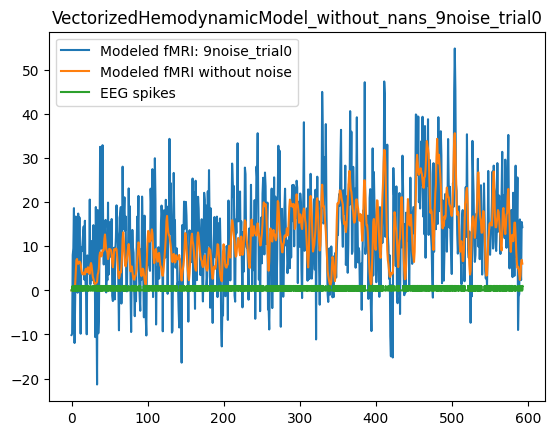

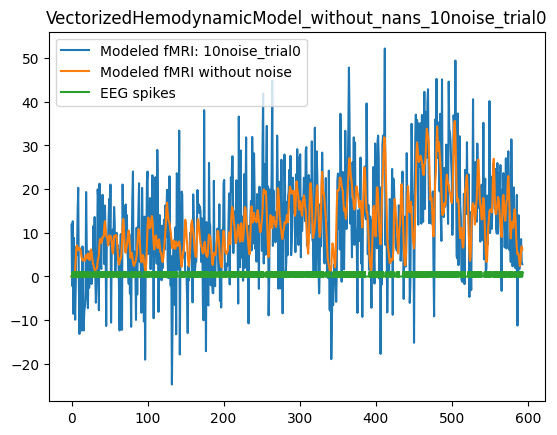

In [5]:
# Generate fMRI data
model_to_fmri = build_model_to_fmri(
    models_to_test,
    eeg_data_options_for_fmri_generation,
    expected_delta,
    expected_tau,
    expected_alpha,
    num_trials,
    num_trials_to_plot,
    noise_range,
    noises_to_plot,
    plot_perfect_comparison,
    tr,
    sample_freq,
    hemodynamic_response_window,
    plot_generated_data
)


## Initialize Analysis variables

In [6]:
step_size = 0.05

filename_substring = f'effect_of_ideal_params_delta{expected_delta}_tau{expected_tau}_alpha{expected_alpha}'
filename_ext = '.csv'
plot = True

delta = np.arange(1, 3+step_size, step_size)
tau = np.arange(0.75, 1.75+step_size, step_size)
alpha = np.arange(1.75, 2.25+step_size, step_size)

print(f'Delta target: {expected_delta}, Range:\n{delta}\n')
print(f'Tau target: {expected_tau}, Range:\n{tau}\n')
print(f'Alpha target: {expected_alpha}, Range:\n{alpha}\n')

Delta target: 2.25, Range:
[1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35 1.4  1.45 1.5  1.55 1.6  1.65
 1.7  1.75 1.8  1.85 1.9  1.95 2.   2.05 2.1  2.15 2.2  2.25 2.3  2.35
 2.4  2.45 2.5  2.55 2.6  2.65 2.7  2.75 2.8  2.85 2.9  2.95 3.  ]

Tau target: 0.95, Range:
[0.75 0.8  0.85 0.9  0.95 1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35 1.4
 1.45 1.5  1.55 1.6  1.65 1.7  1.75]

Alpha target: 2, Range:
[1.75 1.8  1.85 1.9  1.95 2.   2.05 2.1  2.15 2.2  2.25]



## Est vs Actual for all models at correct points

Scoring downsample_without_nans_without_nans delta=2.25, tau=0.95, alpha=2


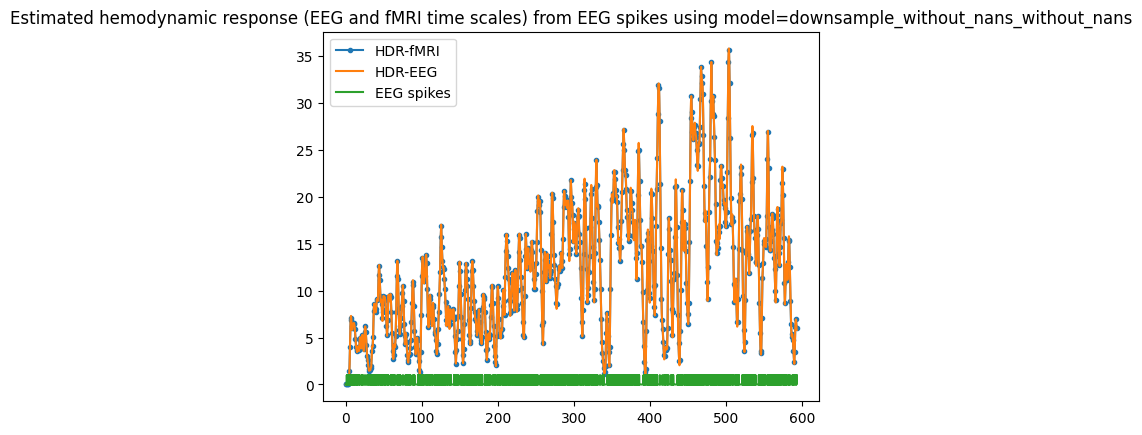

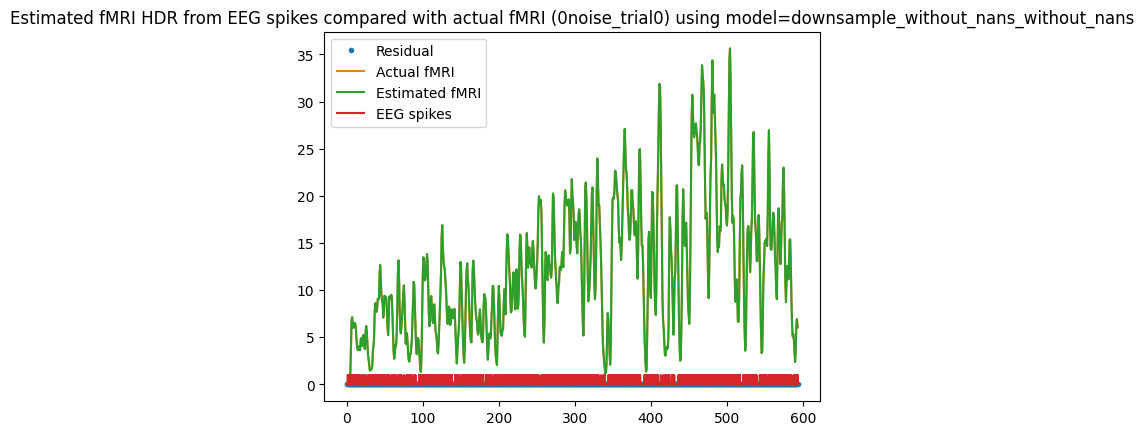

Residual Variance is 0.000000


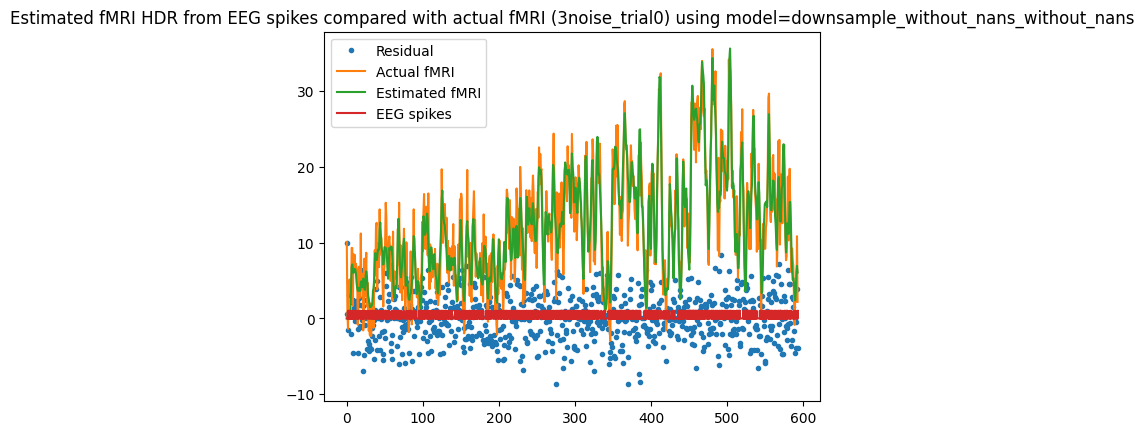

Residual Variance is 8.977674


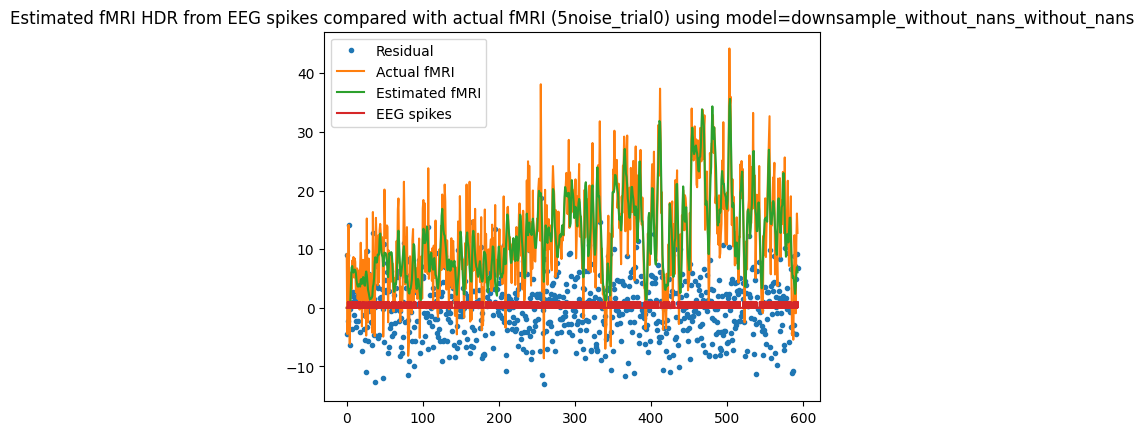

Residual Variance is 25.943802


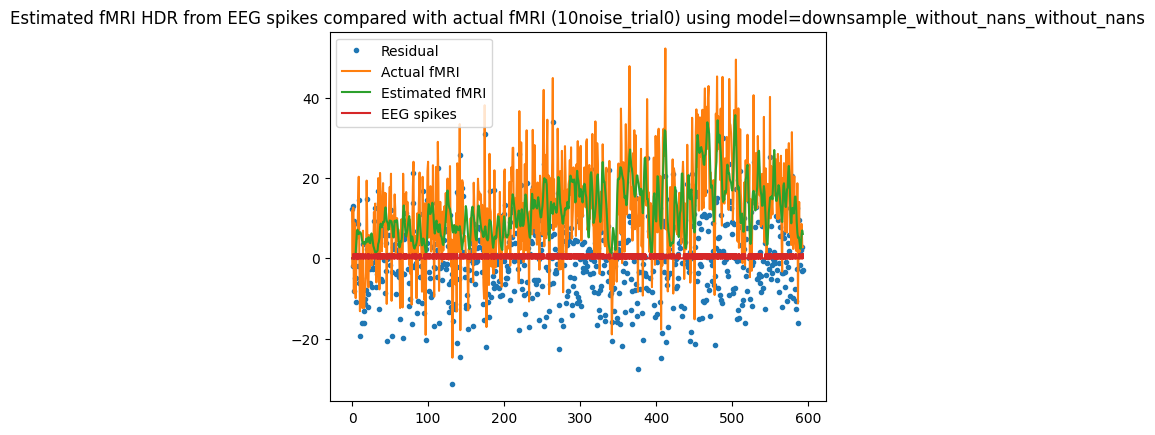

Residual Variance is 98.947661


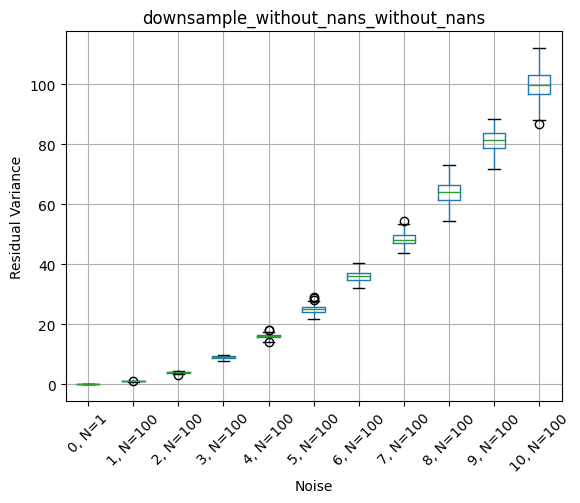

Scoring downsample_without_nans_with_nans delta=2.25, tau=0.95, alpha=2


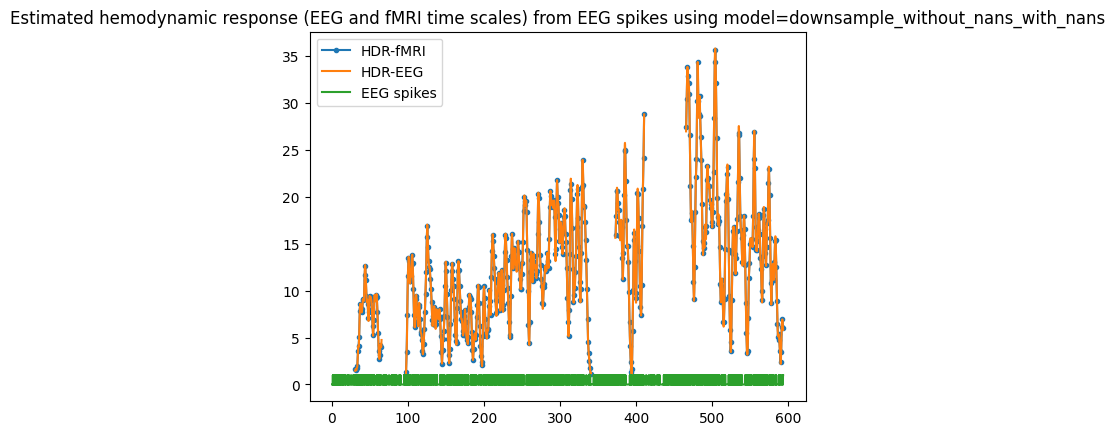

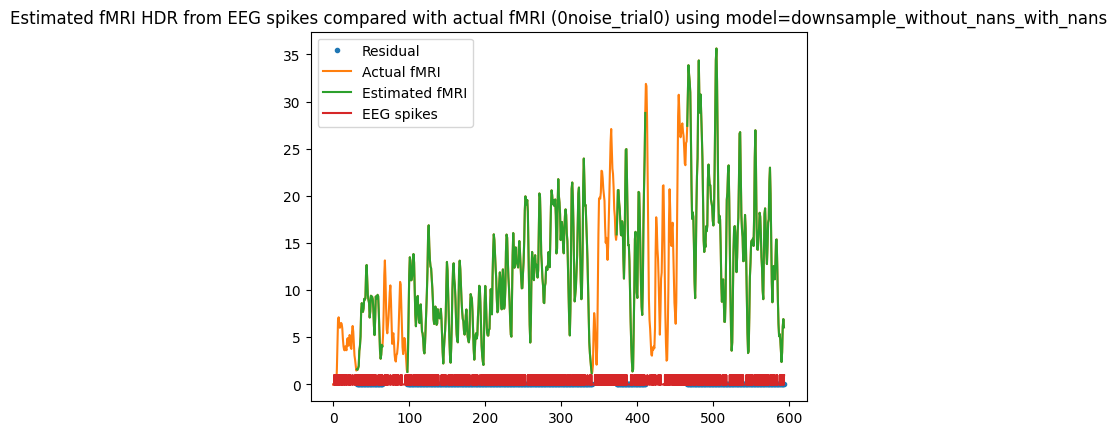

Residual Variance is 0.000000


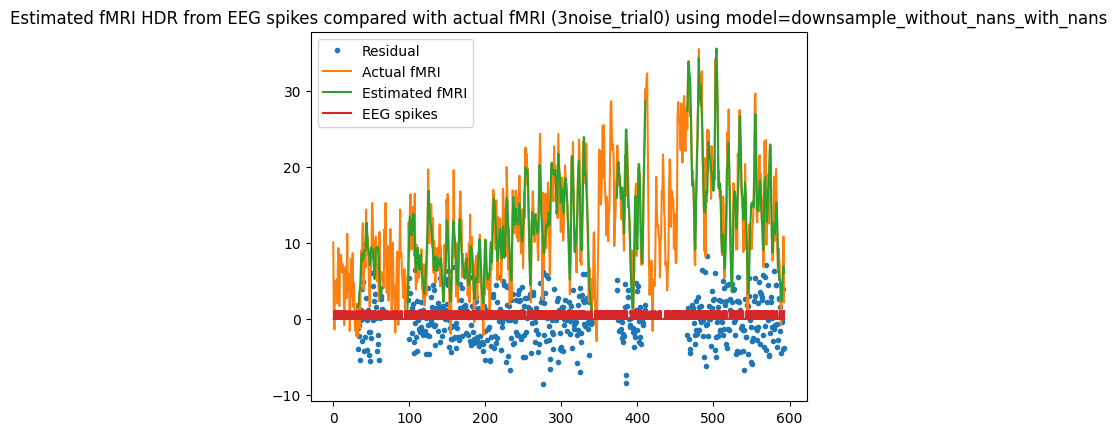

Residual Variance is 8.943739


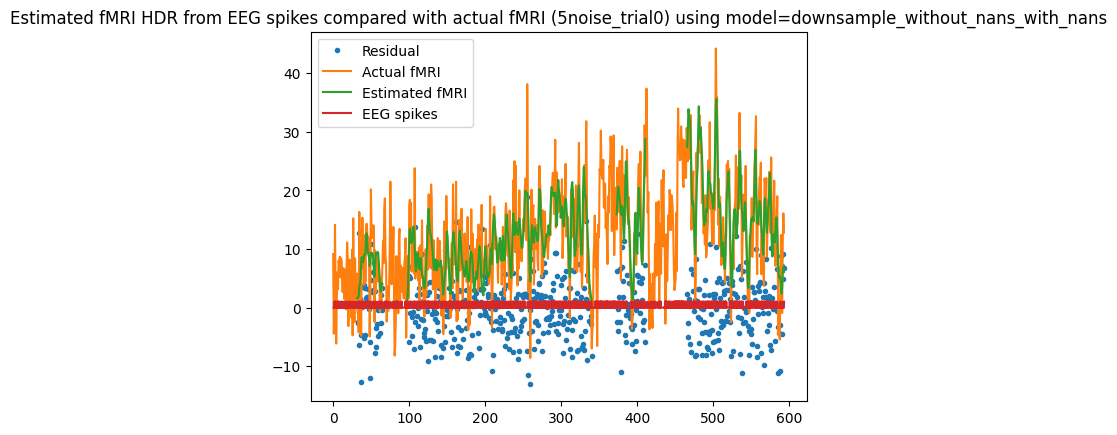

Residual Variance is 25.862465


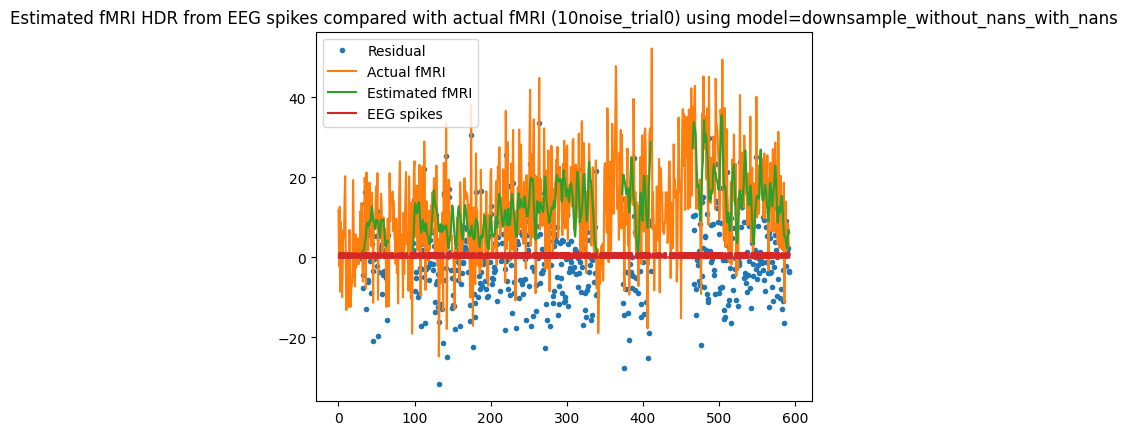

Residual Variance is 96.372358


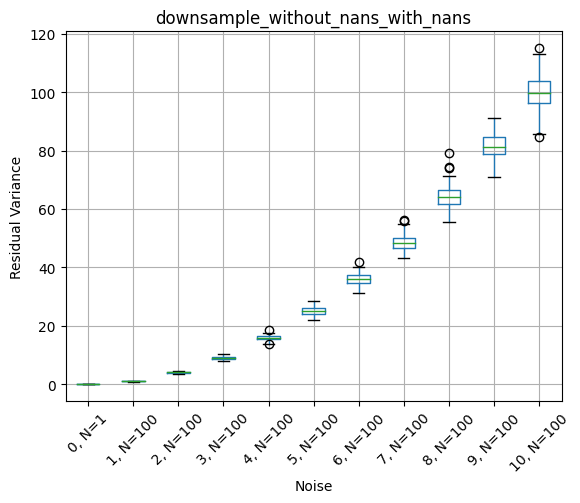

In [7]:
models = build_models(
    model_to_fmri,
    eeg_data_options_for_simulation,
    tr, 
    n_trs_skipped_at_beginning,
    sample_freq,
    hemodynamic_response_window,
    plot
)

# Get in-depth plots for actual delta, tau, alpha
for model_name, model in models.items():
    residual_var = model.score(expected_delta, expected_tau, expected_alpha)
    fmri_names = np.array(model.fmri.voxel_names)
    if (fmri_names == None).any():
        print(f'Residual variance was {residual_var}')
    else:
        noise_levels = np.char.replace(fmri_names, 'perfect', '0noise_trail0')
        noise_levels = np.char.partition(noise_levels, sep='noise')
        res_var_df = pd.DataFrame(zip(noise_levels[:,0].astype(int), residual_var), columns=['Noise', 'res_var'])
        res_var_by_noise = res_var_df.groupby('Noise')
        _, axs = plt.subplots()
        axs.set_title(model_name)
        axs.set_ylabel('Residual Variance')
        axs.set_xlabel('Noise')
        axs = res_var_by_noise.boxplot(column='res_var', subplots=False, rot=45, ax=axs)
        labels = res_var_by_noise.count()
        labels = [f'{noise}, N={n.item()}' for noise, n in zip(labels.index, labels.values)]
        plt.setp(axs, xticklabels=labels)
        plt.show()
    model.plot = False

## Generate/Load the full dataset

In [8]:
# Optional Reuse functionality

df = pd.DataFrame()
descriptions = []

if try_to_reuse:
    matching_files = sorted(glob.glob(f'{filename_substring}*{filename_ext}'))
    filename_to_use = "none"
    if len(matching_files) != 0:
        filename_to_use = input(
            f'Found previously run data. Enter name to reuse or "none" to recalculate.'
            f'\n{matching_files}\nDefault ({matching_files[-1]})\n'
        )
    if filename_to_use.lower() != "none":
        if filename_to_use.strip() == '':
            filename_to_use = matching_files[-1]
        print(f'Loading data from {filename_to_use}...')
        with open(filename_to_use, 'r') as f:
            df = pd.read_csv(f, index_col=0)
        descriptions = generate_descriptions_from_search_df(df, models)


In [9]:
if df.empty:
    if submit_to_cluster:
        raise NotImplemented("Submitting to the cluster is not implemented!")
    print('Generating data!')
    descriptions, df = search_voxels(models, delta, tau, alpha)
    with open(f'{filename_substring}_{datetime.now().strftime("%Y-%m-%d_%H:%M")}{filename_ext}', 'w') as f:
        pd.DataFrame(df).to_csv(f)
    for model_name, description in zip(models.keys(), descriptions):
        with open(f'{model_name}_summary_{filename_substring}_{datetime.now().strftime("%Y-%m-%d_%H:%M")}{filename_ext}', 'w') as f:
            pd.DataFrame(description).transpose().to_csv(f)

df

Generating data!
Scoring delta=1.0
Scoring delta=1.05
Scoring delta=1.1
Scoring delta=1.1500000000000001
Scoring delta=1.2000000000000002
Scoring delta=1.2500000000000002
Scoring delta=1.3000000000000003
Scoring delta=1.3500000000000003
Scoring delta=1.4000000000000004
Scoring delta=1.4500000000000004
Scoring delta=1.5000000000000004
Scoring delta=1.5500000000000005
Scoring delta=1.6000000000000005
Scoring delta=1.6500000000000006
Scoring delta=1.7000000000000006
Scoring delta=1.7500000000000007
Scoring delta=1.8000000000000007
Scoring delta=1.8500000000000008
Scoring delta=1.9000000000000008
Scoring delta=1.9500000000000008
Scoring delta=2.000000000000001
Scoring delta=2.0500000000000007
Scoring delta=2.100000000000001
Scoring delta=2.1500000000000012
Scoring delta=2.200000000000001
Scoring delta=2.250000000000001
Scoring delta=2.300000000000001
Scoring delta=2.3500000000000014
Scoring delta=2.4000000000000012
Scoring delta=2.450000000000001
Scoring delta=2.5000000000000013
Scoring de

delta                 tau               alpha  \
0                     1.0                0.75                1.75   
1                     1.0                0.75                1.75   
2                     1.0                0.75                 1.8   
3                     1.0                0.75                 1.8   
4                     1.0                0.75                1.85   
...                   ...                 ...                 ...   
18937  3.0000000000000018  1.7500000000000009  2.1500000000000004   
18938  3.0000000000000018  1.7500000000000009                 2.2   
18939  3.0000000000000018  1.7500000000000009                 2.2   
18940  3.0000000000000018  1.7500000000000009  2.2500000000000004   
18941  3.0000000000000018  1.7500000000000009  2.2500000000000004   

                                 model_name       0noise_trial0  \
0      downsample_without_nans_without_nans   24.49079179663741   
1         downsample_without_nans_with_nans  23.191903846088476   
2      downsample_without_nans_without_nans   23.77829229983935   
3         downsample_without_nans_with_nans  22.552808603634247   
4      downsample_without_nans_without_nans  23.063426983260243   
...                                     ...                 ...   
18937     downsample_without_nans_with_nans  18.443567916153928   
18938  downsample_without_nans_without_nans   20.38857543235096   
18939     downsample_without_nans_with_nans  18.929747790897277   
18940  downsample_without_nans_without_nans  20.929346906174995   
18941     downsample_without_nans_with_nans   19.40089443090536   

            1noise_trial0       2noise_trial0       3noise_trial0  \
0      25.906266673863033  28.260046545920954  32.254055694550736   
1       24.69835234068911   25.71985644284413  31.101046617836264   
2      25.199665362347474  27.552745194036884  31.570870447494894   
3       24.06732525152829  25.090109035849334  30.473160213818964   
4       24.48998086468174   26.84277146596161  30.885424979245443   
...                   ...                 ...                 ...   
18937  19.185239150796512  21.906437837111856  26.502857013565674   
18938  21.156937366675454  24.463869478024865  28.078490923419903   
18939  19.673746791875093  22.379160456073638  26.962780689683918   
18940   21.70010965496813   25.00667063053157  28.582118000326044   
18941  20.147256689645353   22.83690435513865  27.408499364536333   

            4noise_trial0       5noise_trial0  ...      1noise_trial99  \
0      40.237830651611134  50.453791843747695  ...  25.513284411148472   
1       39.82598646646631  49.601767972840925  ...   23.85225234792752   
2       39.50800090607992   49.76446817487853  ...    24.8018572090162   
3      39.189133090917004   49.00903048898361  ...  23.217491929492375   
4        38.7765645773349   49.07266799724478  ...  24.088128702869614   
...                   ...                 ...  ...                 ...   
18937  33.131899301622745   44.42219372922977  ...   19.27200439209618   
18938  36.281393941043724   46.98869617665232  ...   21.17418246667554   
18939   33.60494505943466  44.938847446490385  ...  19.754599137520753   
18940   36.79717069306577   47.55698712585781  ...  21.715776519069443   
18941   34.06365822833481   45.43939024078472  ...   20.22235273189058   

           2noise_trial99      3noise_trial99      4noise_trial99  \
0      28.687684834102644  32.341791935680824   42.23414252654865   
1      27.786930946646553  31.458041457589875   40.78246342018658   
2       27.98925891333011  31.670138595024273   41.54917808262549   
3       27.15724113176048   30.85427558318272   40.17162189193961   
4      27.288420579971245   30.99646515671697   40.85992119921144   
...                   ...                 ...                 ...   
18937   22.05902303158727   26.21766423495293  33.382427795075294   
18938  23.525345713200124  27.775790615522364    36.1802896101393   
18939  22.550738056918423  26.718232285677345  

## No Noise Analysis - downsample without missing data

### Cost

Minimal Cost for Average Cost: noise 0 (downsample_without_nans_without_nans) = 1.2540750324488934e-28; at
       delta   tau  alpha
11648   2.25  0.95    2.0


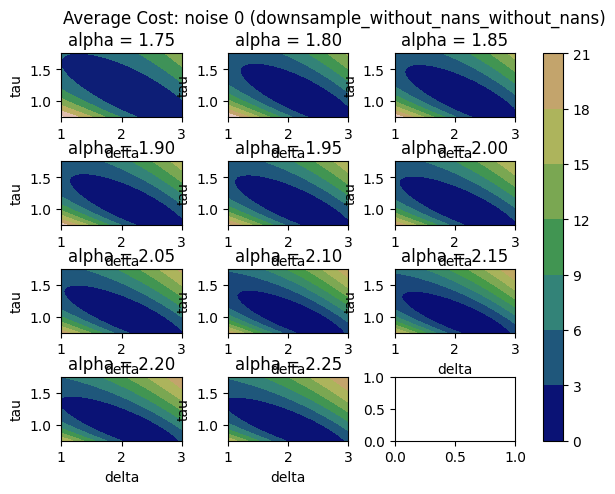

delta   tau  alpha  \
0        1.0  0.75   1.75   
2        1.0  0.75   1.80   
4        1.0  0.75   1.85   
6        1.0  0.75   1.90   
8        1.0  0.75   1.95   
...      ...   ...    ...   
18932    3.0  1.75   2.05   
18934    3.0  1.75   2.10   
18936    3.0  1.75   2.15   
18938    3.0  1.75   2.20   
18940    3.0  1.75   2.25   

       Average Cost: noise 0 (downsample_without_nans_without_nans)  
0                                              24.490792             
2                                              23.778292             
4                                              23.063427             
6                                              22.347063             
8                                              21.630077             
...                                                  ...             
18932                                          18.681039             
18934                                          19.264206             
18936                                          19.833468             
18938                                          20.388575             
18940                                          20.929347             

[9471 rows x 4 columns]

In [10]:
model_name = 'downsample_without_nans_without_nans'
noise = 0
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
columns_for_noise = df_to_plot.columns[columns_to_choose]

average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]

average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
plot_all_search_results_2d(average_df, separate_by='alpha')
average_df


In [11]:
data = []

minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()

for point in zip(*np.where(~np.isnan(minimum_cost_array))):
    row_of_interest = df_to_plot.iloc[point[0]]
    data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha']])
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
pd.DataFrame(data, columns=['delta', 'tau', 'alpha'])

Delta target: 2.25, Tau target: 0.95, Alpha target: 2


delta   tau  alpha
0   2.25  0.95    2.0

### Local Minima Analysis

In [12]:
delta_unique_values = df_to_plot['delta'].unique()    
tau_unique_values = df_to_plot['tau'].unique()
alpha_unique_values = df_to_plot['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(df_to_plot['delta'].values, new_shape)
tau_pts = np.reshape(df_to_plot['tau'].values, new_shape)
alpha_pts = np.reshape(df_to_plot['alpha'].values, new_shape)

# Find local minima
columns = df_to_plot.columns.drop(['delta', 'tau', 'alpha'])

m = np.reshape(
    df_to_plot[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
noise = 0

columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
for point in local_minima_with_given_noise:
    point_as_list = tuple(point.tolist())
    local_minima.append({
        'noise': noise,
        'iteration': columns[point[-1]].split('trial')[-1],
        'cost': m[point_as_list],
        'delta': delta_pts[point_as_list[:-1]],
        'tau': tau_pts[point_as_list[:-1]],
        'alpha': alpha_pts[point_as_list[:-1]]
    })

local_minima_by_noise = pd.DataFrame(local_minima)
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
local_minima_by_noise

Delta target: 2.25, Tau target: 0.95, Alpha target: 2


noise iteration          cost  delta   tau  alpha
0      0         0  3.032282e-03   2.15  0.90   2.25
1      0         0  1.254075e-28   2.25  0.95   2.00
2      0         0  6.851490e-03   2.30  1.00   1.85
3      0         0  7.042045e-03   2.35  1.00   1.75

In [13]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').mean()

Number of Local Minima
noise                        
0                         4.0

#### Local minima at edges

In [14]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [15]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [16]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [17]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [18]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

noise iteration      cost  delta  tau  alpha
3      0         0  0.007042   2.35  1.0   1.75

In [19]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

noise iteration      cost  delta  tau  alpha
0      0         0  0.003032   2.15  0.9   2.25

## No Noise Analysis - downsample with missing data

### Cost

Minimal Cost for Average Cost: noise 0 (downsample_without_nans_with_nans) = 7.325511436342705e-29; at
       delta   tau  alpha
11649   2.25  0.95    2.0


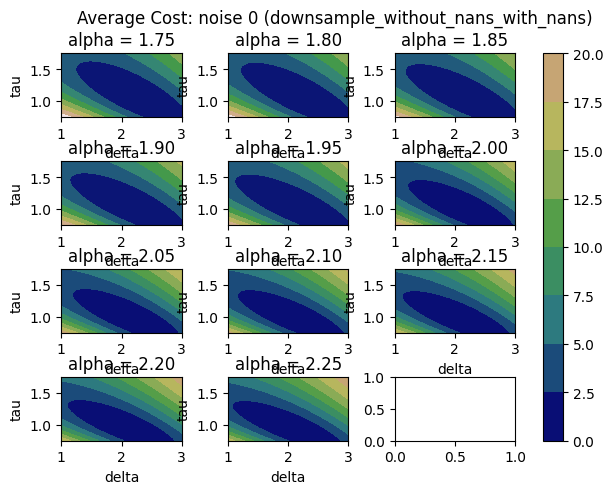

delta   tau  alpha  \
1        1.0  0.75   1.75   
3        1.0  0.75   1.80   
5        1.0  0.75   1.85   
7        1.0  0.75   1.90   
9        1.0  0.75   1.95   
...      ...   ...    ...   
18933    3.0  1.75   2.05   
18935    3.0  1.75   2.10   
18937    3.0  1.75   2.15   
18939    3.0  1.75   2.20   
18941    3.0  1.75   2.25   

       Average Cost: noise 0 (downsample_without_nans_with_nans)  
1                                              23.191904          
3                                              22.552809          
5                                              21.909142          
7                                              21.261699          
9                                              20.611299          
...                                                  ...          
18933                                          17.426426          
18935                                          17.942418          
18937                                          18.443568          
18939                                          18.929748          
18941                                          19.400894          

[9471 rows x 4 columns]

In [20]:
model_name = 'downsample_without_nans_with_nans'
noise = 0
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
columns_for_noise = df_to_plot.columns[columns_to_choose]

average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]

average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
plot_all_search_results_2d(average_df, separate_by='alpha')
average_df


In [21]:
data = []

minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()

for point in zip(*np.where(~np.isnan(minimum_cost_array))):
    row_of_interest = df_to_plot.iloc[point[0]]
    data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha']])
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
pd.DataFrame(data, columns=['delta', 'tau', 'alpha'])

Delta target: 2.25, Tau target: 0.95, Alpha target: 2


delta   tau  alpha
0   2.25  0.95    2.0

### Local Minima Analysis

In [22]:
delta_unique_values = df_to_plot['delta'].unique()    
tau_unique_values = df_to_plot['tau'].unique()
alpha_unique_values = df_to_plot['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(df_to_plot['delta'].values, new_shape)
tau_pts = np.reshape(df_to_plot['tau'].values, new_shape)
alpha_pts = np.reshape(df_to_plot['alpha'].values, new_shape)

# Find local minima
columns = df_to_plot.columns.drop(['delta', 'tau', 'alpha'])

m = np.reshape(
    df_to_plot[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
noise = 0

columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
for point in local_minima_with_given_noise:
    point_as_list = tuple(point.tolist())
    local_minima.append({
        'noise': noise,
        'iteration': columns[point[-1]].split('trial')[-1],
        'cost': m[point_as_list],
        'delta': delta_pts[point_as_list[:-1]],
        'tau': tau_pts[point_as_list[:-1]],
        'alpha': alpha_pts[point_as_list[:-1]]
    })

local_minima_by_noise = pd.DataFrame(local_minima)
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
local_minima_by_noise

Delta target: 2.25, Tau target: 0.95, Alpha target: 2


noise iteration          cost  delta   tau  alpha
0      0         0  3.043524e-03   2.15  0.90   2.25
1      0         0  7.325511e-29   2.25  0.95   2.00
2      0         0  6.303204e-03   2.30  1.00   1.85
3      0         0  7.250870e-03   2.35  1.00   1.75

In [23]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').mean()

Number of Local Minima
noise                        
0                         4.0

#### Local minima at edges

In [24]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [25]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [26]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [27]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [28]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

noise iteration      cost  delta  tau  alpha
3      0         0  0.007251   2.35  1.0   1.75

In [29]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

noise iteration      cost  delta  tau  alpha
0      0         0  0.003044   2.15  0.9   2.25

## Cost by Noise

### Downsample without Missing Data

Minimal Cost for Average Cost: noise 1 (downsample_without_nans_without_nans) = 0.9964431066901653; at
       delta   tau  alpha
11648   2.25  0.95    2.0


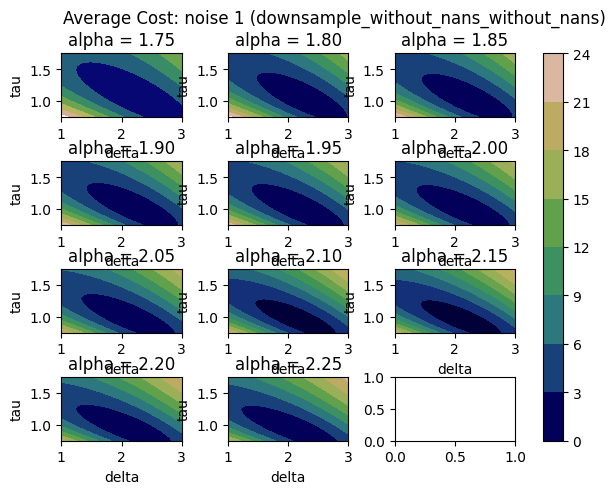

Minimal Cost for Average Cost: noise 2 (downsample_without_nans_without_nans) = 3.984229381826505; at
       delta   tau  alpha
11648   2.25  0.95    2.0


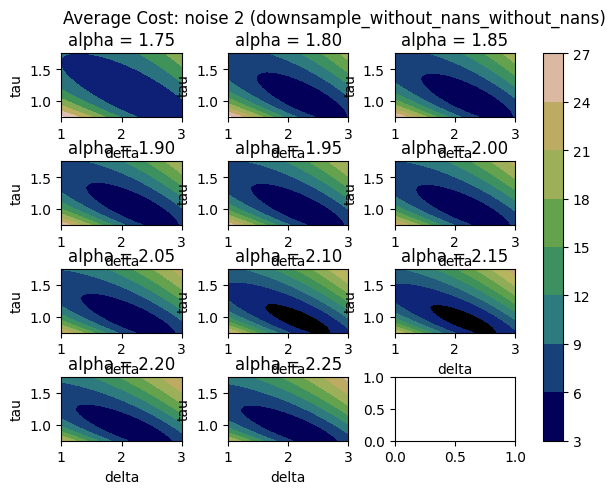

Minimal Cost for Average Cost: noise 3 (downsample_without_nans_without_nans) = 8.981652873569471; at
       delta   tau  alpha
11648   2.25  0.95    2.0


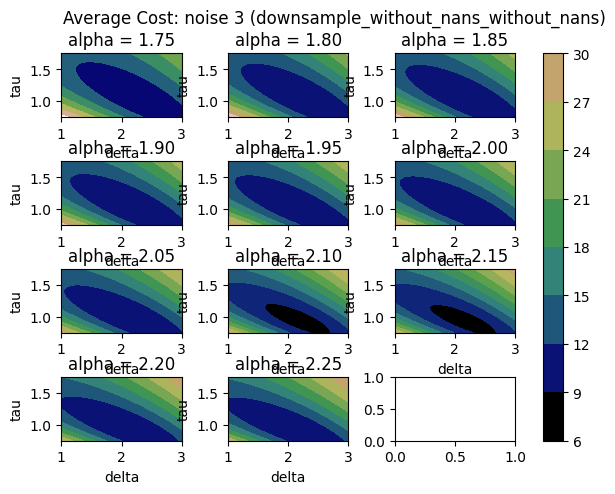

Minimal Cost for Average Cost: noise 4 (downsample_without_nans_without_nans) = 15.994927881336935; at
       delta   tau  alpha
11648   2.25  0.95    2.0


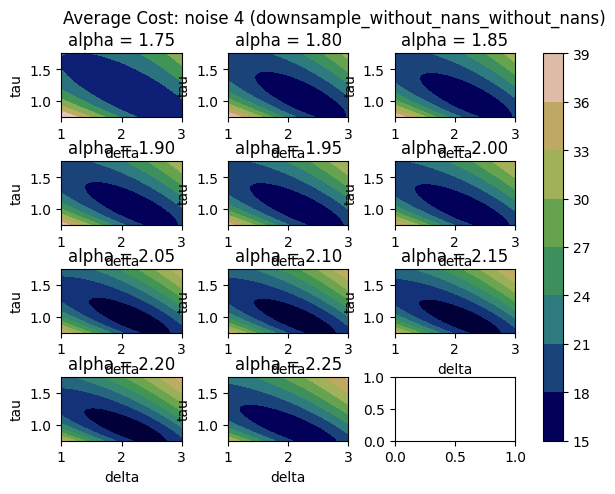

Minimal Cost for Average Cost: noise 5 (downsample_without_nans_without_nans) = 25.00959577539563; at
       delta   tau  alpha
11648   2.25  0.95    2.0


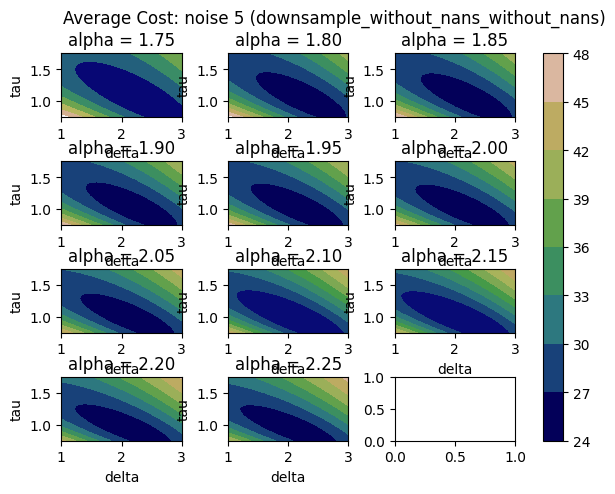

Minimal Cost for Average Cost: noise 6 (downsample_without_nans_without_nans) = 36.0365352291144; at
       delta   tau  alpha
11648   2.25  0.95    2.0


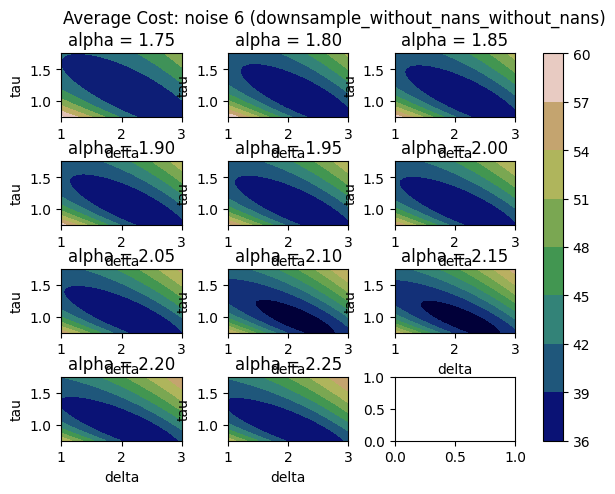

Minimal Cost for Average Cost: noise 7 (downsample_without_nans_without_nans) = 48.5651497307976; at
       delta   tau  alpha
11648   2.25  0.95    2.0


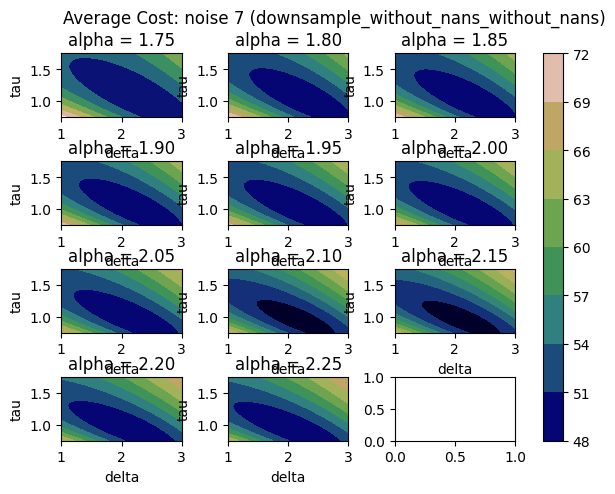

Minimal Cost for Average Cost: noise 8 (downsample_without_nans_without_nans) = 64.02167100597666; at
       delta   tau  alpha
11648   2.25  0.95    2.0


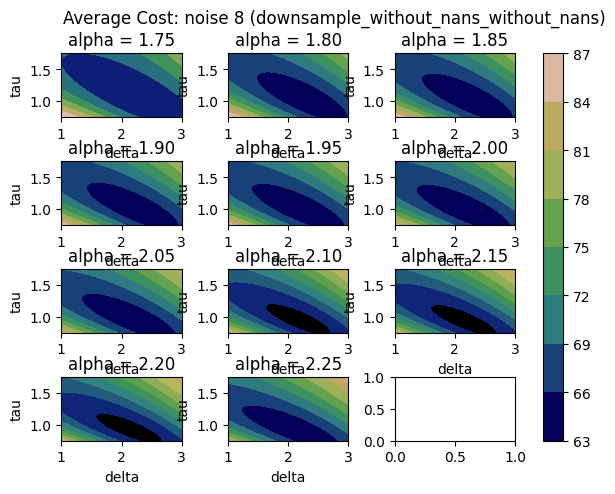

Minimal Cost for Average Cost: noise 9 (downsample_without_nans_without_nans) = 81.09615001349833; at
       delta   tau  alpha
11648   2.25  0.95    2.0


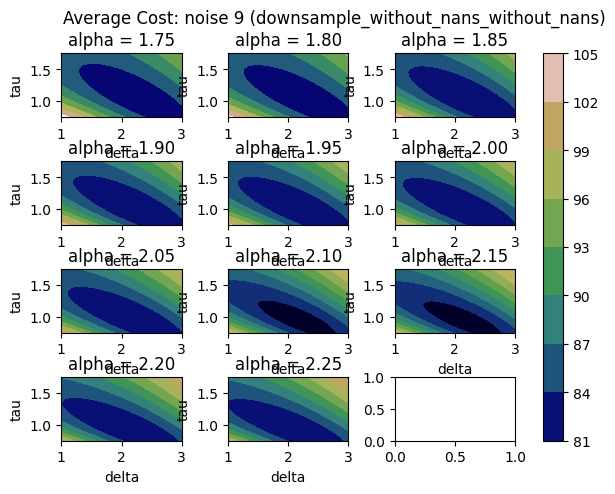

Minimal Cost for Average Cost: noise 10 (downsample_without_nans_without_nans) = 99.67794420728615; at
       delta   tau  alpha
12108    2.3  0.95   1.95


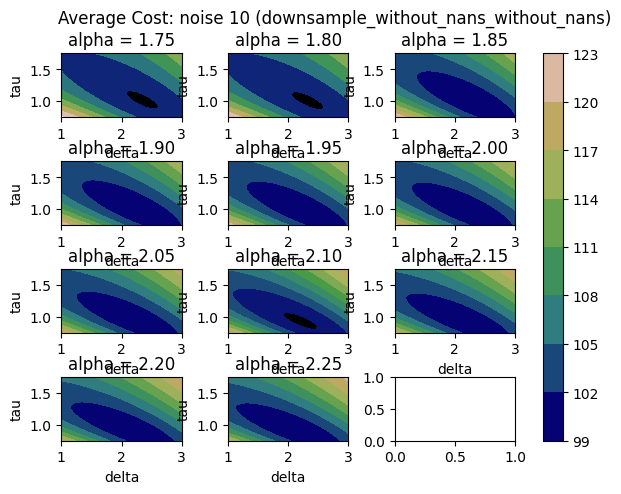

In [30]:
model_name = 'downsample_without_nans_without_nans'
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]

    average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]
    average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
    plot_all_search_results_2d(average_df, separate_by='alpha')

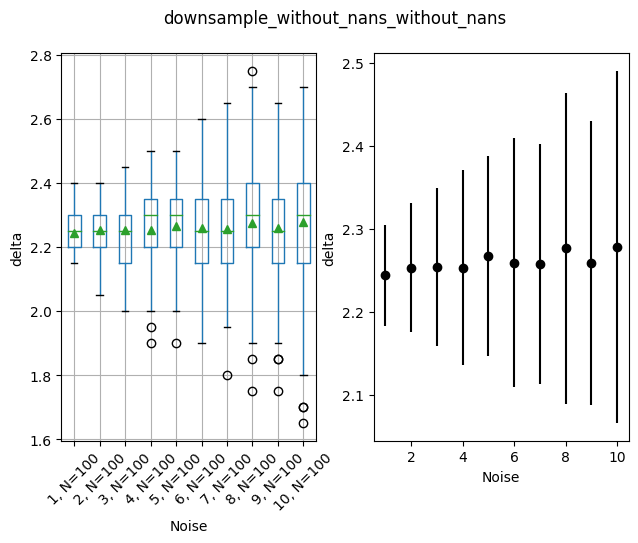

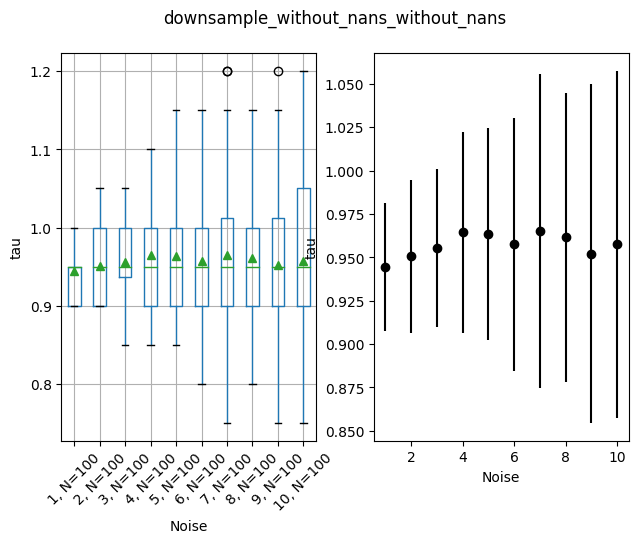

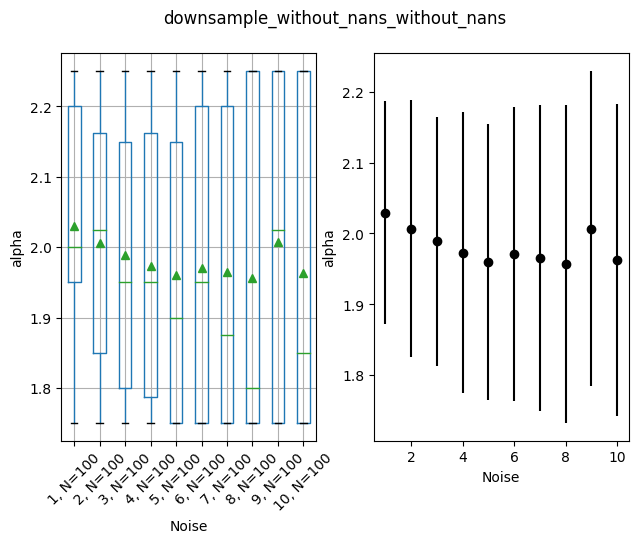

In [31]:
data = []
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]
    minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
    minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()
    
    for point in zip(*np.where(~np.isnan(minimum_cost_array))):
        row_of_interest = df_to_plot.iloc[point[0]]
        data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha'], noise])

chosen_points = pd.DataFrame(data, columns=['delta', 'tau', 'alpha', 'noise']).groupby('noise')

for variable in ['delta', 'tau', 'alpha']:
    fig, axs = plt.subplots(1, 2)
    fig.suptitle(model_name)
    fig.tight_layout()
    axs[0].set_ylabel(variable)
    axs[0].set_xlabel('Noise')
    axs[0] = chosen_points.boxplot(subplots=False, column=variable, rot=45, ax=axs[0], showmeans=True)
    axs[1].set_ylabel(variable)
    axs[1].set_xlabel('Noise')
    axs[1].errorbar(noise_range, chosen_points.mean()[variable], chosen_points.std()[variable], fmt='ok')
    labels = chosen_points.count()
    labels = [f'{noise}, N={n[0].item()}' for noise, n in zip(labels.index, labels.values)]
    plt.setp(axs[0], xticklabels=labels)
    plt.show()

### Downsample with Missing Data

Minimal Cost for Average Cost: noise 1 (downsample_without_nans_with_nans) = 0.9974913471408425; at
       delta   tau  alpha
11649   2.25  0.95    2.0


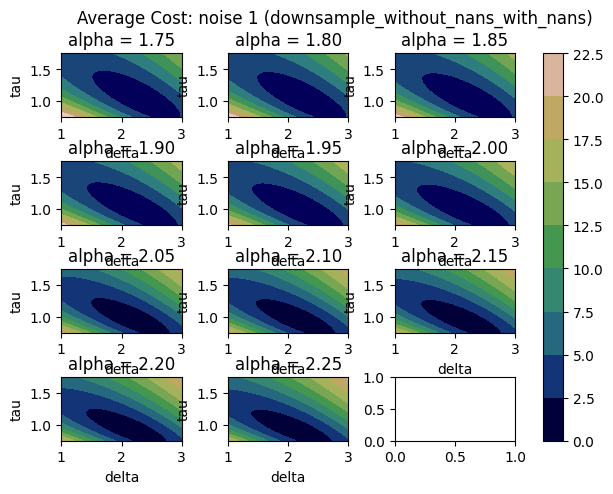

Minimal Cost for Average Cost: noise 2 (downsample_without_nans_with_nans) = 4.0049762931126365; at
       delta   tau  alpha
11649   2.25  0.95    2.0


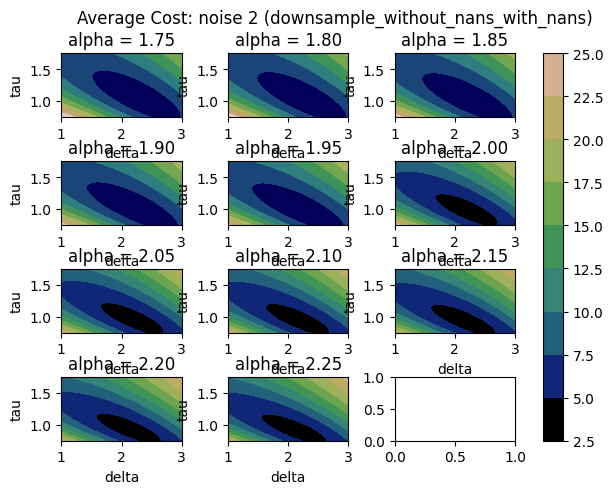

Minimal Cost for Average Cost: noise 3 (downsample_without_nans_with_nans) = 9.004926643935766; at
       delta   tau  alpha
11649   2.25  0.95    2.0


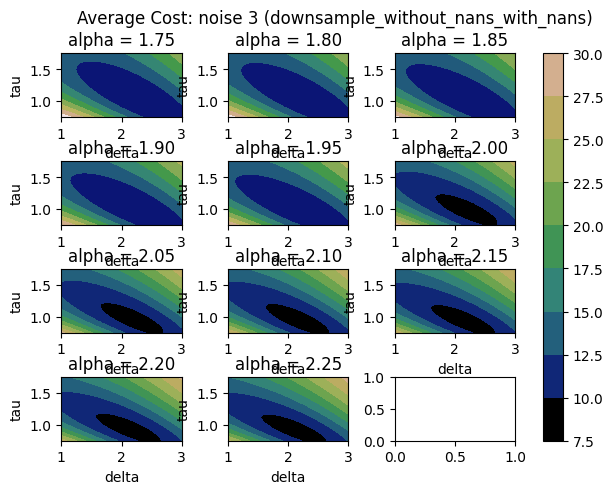

Minimal Cost for Average Cost: noise 4 (downsample_without_nans_with_nans) = 15.941415848357426; at
       delta   tau  alpha
11649   2.25  0.95    2.0


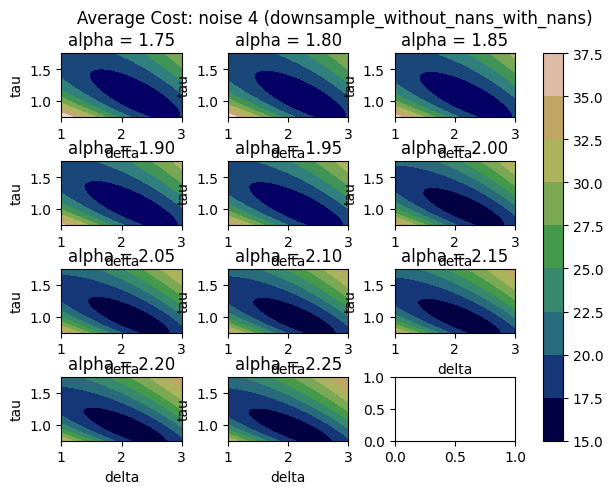

Minimal Cost for Average Cost: noise 5 (downsample_without_nans_with_nans) = 25.043647481567632; at
       delta  tau  alpha
12127    2.3  1.0   1.85


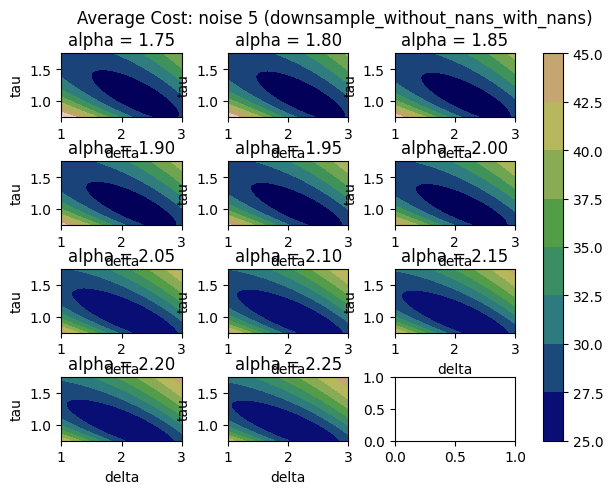

Minimal Cost for Average Cost: noise 6 (downsample_without_nans_with_nans) = 36.10119217245389; at
       delta   tau  alpha
11649   2.25  0.95    2.0


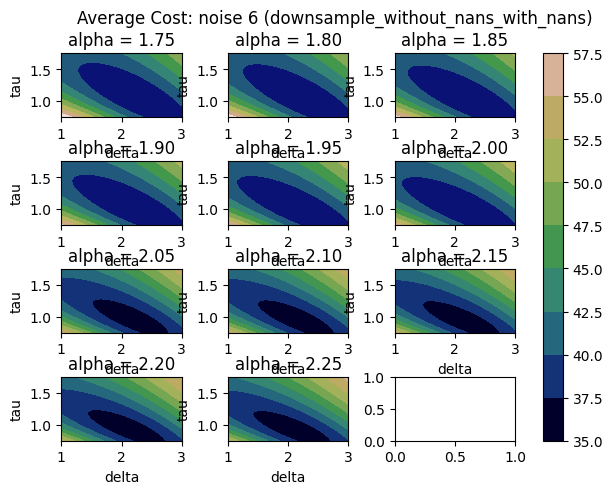

Minimal Cost for Average Cost: noise 7 (downsample_without_nans_with_nans) = 48.571896451697; at
       delta   tau  alpha
11649   2.25  0.95    2.0


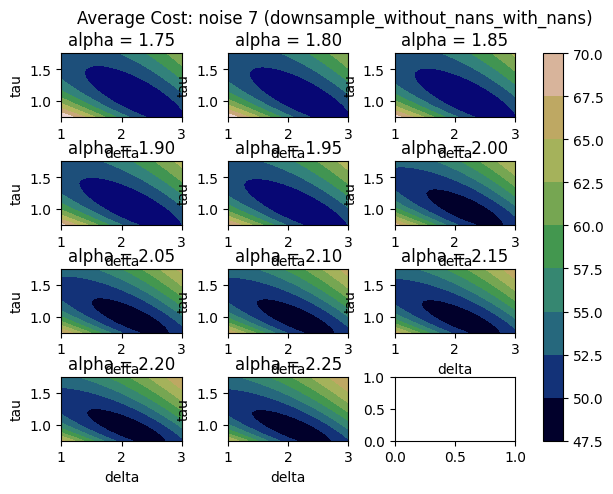

Minimal Cost for Average Cost: noise 8 (downsample_without_nans_with_nans) = 64.27301825010255; at
       delta  tau  alpha
12127    2.3  1.0   1.85


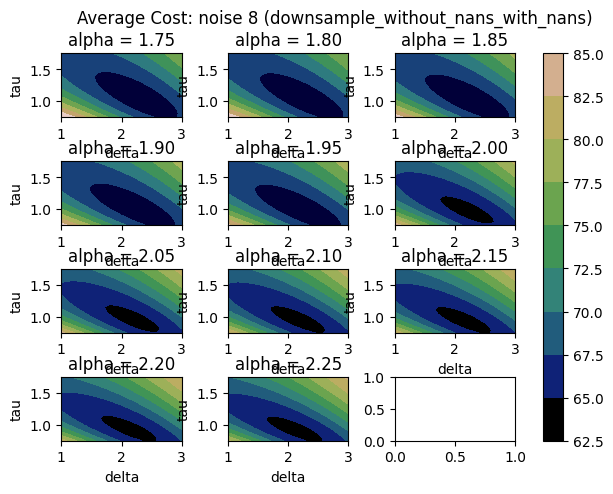

Minimal Cost for Average Cost: noise 9 (downsample_without_nans_with_nans) = 81.47097603819435; at
       delta   tau  alpha
11649   2.25  0.95    2.0


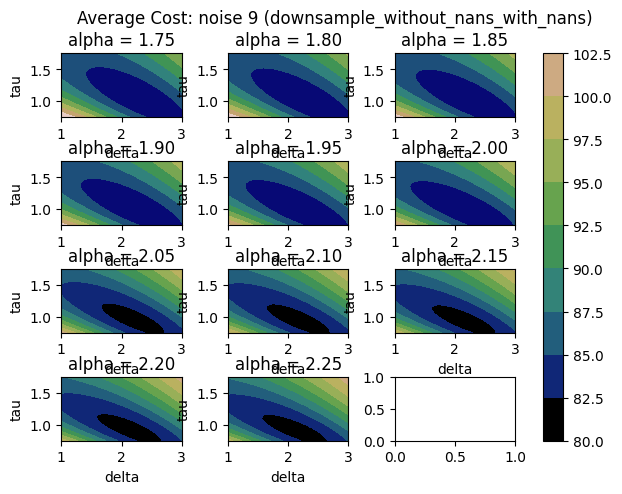

Minimal Cost for Average Cost: noise 10 (downsample_without_nans_with_nans) = 99.79358029571341; at
       delta  tau  alpha
12585   2.35  1.0   1.75


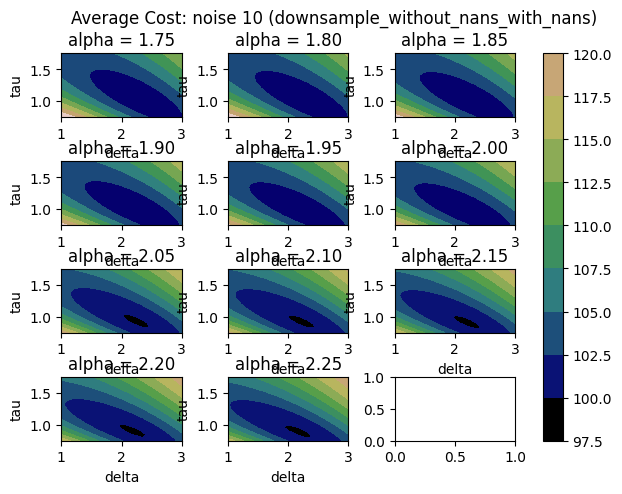

In [32]:
model_name = 'downsample_without_nans_with_nans'
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]

    average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]
    average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
    plot_all_search_results_2d(average_df, separate_by='alpha')


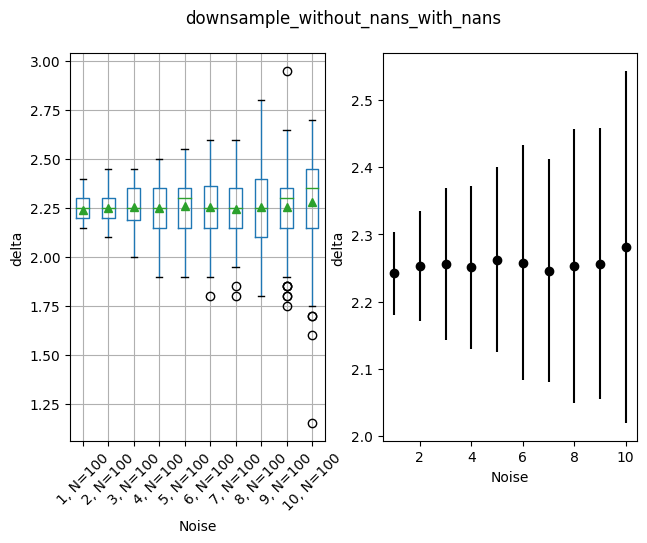

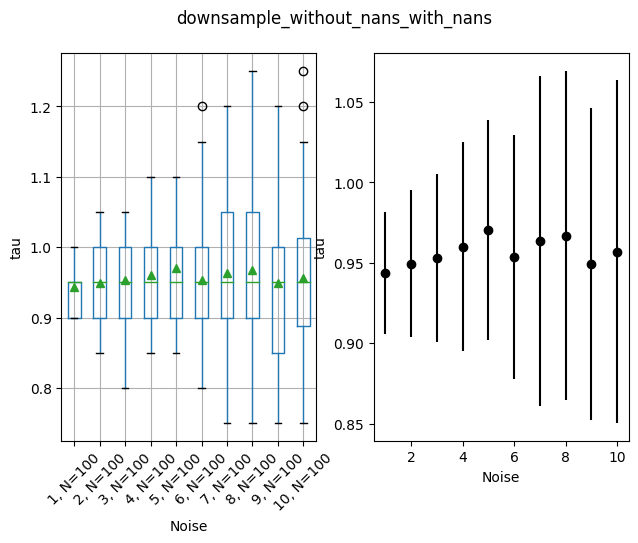

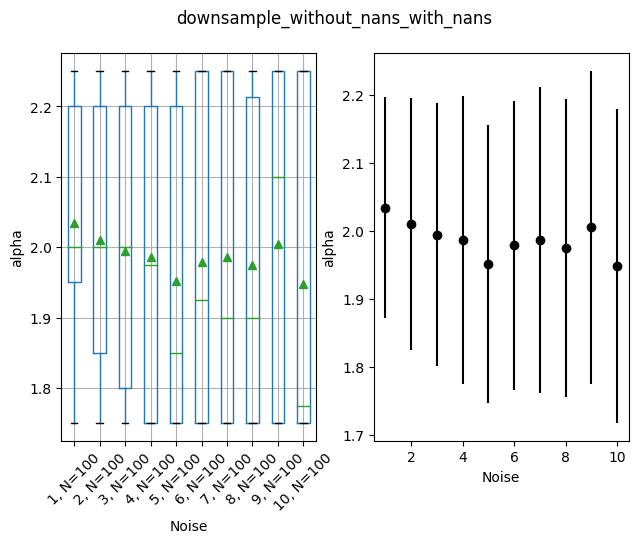

In [33]:
data = []
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]
    minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
    minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()
    
    for point in zip(*np.where(~np.isnan(minimum_cost_array))):
        row_of_interest = df_to_plot.iloc[point[0]]
        data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha'], noise])

chosen_points = pd.DataFrame(data, columns=['delta', 'tau', 'alpha', 'noise']).groupby('noise')

for variable in ['delta', 'tau', 'alpha']:
    fig, axs = plt.subplots(1, 2)
    fig.suptitle(model_name)
    fig.tight_layout()
    axs[0].set_ylabel(variable)
    axs[0].set_xlabel('Noise')
    axs[0] = chosen_points.boxplot(subplots=False, column=variable, rot=45, ax=axs[0], showmeans=True)
    axs[1].set_ylabel(variable)
    axs[1].set_xlabel('Noise')
    axs[1].errorbar(noise_range, chosen_points.mean()[variable], chosen_points.std()[variable], fmt='ok')
    labels = chosen_points.count()
    labels = [f'{noise}, N={n[0].item()}' for noise, n in zip(labels.index, labels.values)]
    plt.setp(axs[0], xticklabels=labels)
    plt.show()

## Local Minima Analysis

### Downsample without missing data

In [34]:
model = df['model_name'].unique()[0]
print(f"For Model '{model}'")
portion_df = df[df['model_name'] == model].drop(columns='model_name')
delta_unique_values = portion_df['delta'].unique()    
tau_unique_values = portion_df['tau'].unique()
alpha_unique_values = portion_df['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(portion_df['delta'].values, new_shape)
tau_pts = np.reshape(portion_df['tau'].values, new_shape)
alpha_pts = np.reshape(portion_df['alpha'].values, new_shape)

For Model 'downsample_without_nans_without_nans'


In [35]:
# Find local minima
columns = portion_df.columns.drop(['delta', 'tau', 'alpha'])
     
m = np.reshape(
    portion_df[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

In [36]:
local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
for noise in noise_range:
    columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
    local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
    for point in local_minima_with_given_noise:
        point_as_list = tuple(point.tolist())
        local_minima.append({
            'noise': noise,
            'iteration': columns[point[-1]].split('trial')[-1],
            'cost': m[point_as_list],
            'delta': delta_pts[point_as_list[:-1]],
            'tau': tau_pts[point_as_list[:-1]],
            'alpha': alpha_pts[point_as_list[:-1]]
        })

local_minima_by_noise = pd.DataFrame(local_minima)
local_minima_by_noise


noise iteration        cost               delta                 tau  \
0         1         1    0.976832  2.1500000000000012  0.9000000000000001   
1         1         2    1.019311  2.1500000000000012  0.9000000000000001   
2         1         3    0.993036  2.1500000000000012  0.9000000000000001   
3         1         4    0.964552  2.1500000000000012  0.9000000000000001   
4         1        10    1.006237  2.1500000000000012  0.9000000000000001   
...     ...       ...         ...                 ...                 ...   
2692     10        59   94.435804  2.6500000000000012  0.9000000000000001   
2693     10        79   92.052389  2.6500000000000012  0.9000000000000001   
2694     10        47  108.179679  2.7000000000000015                0.75   
2695     10        74   97.546912  2.7000000000000015  0.9000000000000001   
2696     10        47  108.211915  2.7500000000000018                 0.8   

                   alpha  
0     2.2500000000000004  
1     2.2500000000000004  
2     2.2500000000000004  
3     2.2500000000000004  
4     2.2500000000000004  
...                  ...  
2692                1.75  
2693                1.85  
2694  2.1500000000000004  
2695                1.75  
2696  1.9000000000000001  

[2697 rows x 6 columns]

In [37]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').describe()

Number of Local Minima                                         
                       count  mean       std  min  25%  50%  75%  max
noise                                                                
1                      100.0  3.15  0.435194  2.0  3.0  3.0  3.0  5.0
2                      100.0  3.24  0.621500  2.0  3.0  3.0  3.0  5.0
3                      100.0  3.08  0.614308  2.0  3.0  3.0  3.0  5.0
4                      100.0  2.80  0.696311  1.0  3.0  3.0  3.0  4.0
5                      100.0  2.83  0.739301  1.0  2.0  3.0  3.0  5.0
6                      100.0  2.53  0.915136  1.0  2.0  3.0  3.0  5.0
7                      100.0  2.40  0.963998  1.0  2.0  3.0  3.0  5.0
8                      100.0  2.48  0.989643  1.0  2.0  3.0  3.0  5.0
9                      100.0  2.18  0.978352  1.0  1.0  2.0  3.0  5.0
10                     100.0  2.28  1.035530  1.0  1.0  2.0  3.0  5.0

#### Local minima at edges

In [38]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [39]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [40]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

noise iteration        cost               delta   tau  \
1976      7        34   48.707443   2.450000000000001  0.75   
1977      7        77   47.954886   2.450000000000001  0.75   
2208      8         4   72.749981   2.450000000000001  0.75   
2224      8         4   72.747932  2.5000000000000013  0.75   
2233      8        39   64.304405  2.5500000000000016  0.75   
2234      8        65   66.487181  2.5500000000000016  0.75   
2398      9        17   83.821825  2.3500000000000014  0.75   
2438      9        49   81.766340   2.450000000000001  0.75   
2637     10        23   96.258040   2.450000000000001  0.75   
2661     10        23   96.254058  2.5000000000000013  0.75   
2662     10        65  103.585665  2.5000000000000013  0.75   
2694     10        47  108.179679  2.7000000000000015  0.75   

                   alpha  
1976  2.2500000000000004  
1977  2.2500000000000004  
2208  2.2500000000000004  
2224  2.1500000000000004  
2233  1.9500000000000002  
2234                 2.2  
2398  2.2500000000000004  
2438  2.2500000000000004  
2637  2.1000000000000005  
2661                 2.0  
2662  2.2500000000000004  
2694  2.1500000000000004

In [41]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [42]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

noise iteration       cost               delta                 tau alpha
257       1        76   1.019095   2.300000000000001  1.0500000000000003  1.75
260       1         3   1.002401  2.3500000000000014  1.0000000000000002  1.75
261       1        13   1.009229  2.3500000000000014  1.0000000000000002  1.75
262       1        16   0.908504  2.3500000000000014  1.0000000000000002  1.75
263       1        21   1.013002  2.3500000000000014  1.0000000000000002  1.75
...     ...       ...        ...                 ...                 ...   ...
2687     10        19  98.242444  2.6000000000000014  0.9000000000000001  1.75
2688     10        89  96.392971  2.6000000000000014  0.9000000000000001  1.75
2690     10        29  91.181466  2.6000000000000014  0.9500000000000002  1.75
2692     10        59  94.435804  2.6500000000000012  0.9000000000000001  1.75
2695     10        74  97.546912  2.7000000000000015  0.9000000000000001  1.75

[440 rows x 6 columns]

In [43]:
alpha_min.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

delta                                   tau                             \
      count unique                 top freq count unique                 top   
noise                                                                          
1        35      3  2.3500000000000014   32    35      2  1.0000000000000002   
10       51     15   2.300000000000001    7    51      7  1.0500000000000003   
2        45      4  2.3500000000000014   22    45      2  1.0000000000000002   
3        32      5  2.4000000000000012   12    32      3  1.0000000000000002   
4        43      7  2.3500000000000014   13    43      4  1.0500000000000003   
5        43      9   2.300000000000001   12    43      6  1.0500000000000003   
6        49     10  2.3500000000000014   10    49      7  1.0500000000000003   
7        51     10  2.3500000000000014   11    51      7  1.0000000000000002   
8        52     14  2.3500000000000014    9    52      8  1.0000000000000002   
9        39     12   2.300000000000001    7    39      8  1.0000000000000002   

            
      freq  
noise       
1       34  
10      14  
2       34  
3       20  
4       17  
5       17  
6       15  
7       14  
8       14  
9       10

In [44]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

noise iteration        cost               delta                 tau  \
0         1         1    0.976832  2.1500000000000012  0.9000000000000001   
1         1         2    1.019311  2.1500000000000012  0.9000000000000001   
2         1         3    0.993036  2.1500000000000012  0.9000000000000001   
3         1         4    0.964552  2.1500000000000012  0.9000000000000001   
4         1        10    1.006237  2.1500000000000012  0.9000000000000001   
...     ...       ...         ...                 ...                 ...   
2641     10        83  107.835916   2.450000000000001                 0.8   
2647     10        67  105.805151   2.450000000000001  0.8500000000000001   
2662     10        65  103.585665  2.5000000000000013                0.75   
2663     10        55  102.228230  2.5000000000000013                 0.8   
2676     10        79   92.055250  2.5500000000000016                 0.8   

                   alpha  
0     2.2500000000000004  
1     2.2500000000000004  
2     2.2500000000000004  
3     2.2500000000000004  
4     2.2500000000000004  
...                  ...  
2641  2.2500000000000004  
2647  2.2500000000000004  
2662  2.2500000000000004  
2663  2.2500000000000004  
2676  2.2500000000000004  

[448 rows x 6 columns]

In [45]:
alpha_max.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

delta                                   tau                             \
      count unique                 top freq count unique                 top   
noise                                                                          
1        44      2  2.1500000000000012   43    44      1  0.9000000000000001   
10       47     17   2.200000000000001    5    47      8  0.9000000000000001   
2        49      5  2.1500000000000012   39    49      3  0.9000000000000001   
3        48      7  2.1500000000000012   18    48      3  0.9000000000000001   
4        42      9  2.1500000000000012    9    42      4  0.9000000000000001   
5        45      8   2.200000000000001   13    45      4  0.9000000000000001   
6        37     10   2.200000000000001    8    37      6  0.9000000000000001   
7        36     11   2.200000000000001    7    36      6  0.9000000000000001   
8        47     13  2.1500000000000012    9    47      8  0.9000000000000001   
9        53     16  2.1500000000000012   10    53      8  0.9000000000000001   

            
      freq  
noise       
1       44  
10      11  
2       45  
3       31  
4       20  
5       27  
6       15  
7       15  
8       17  
9       15

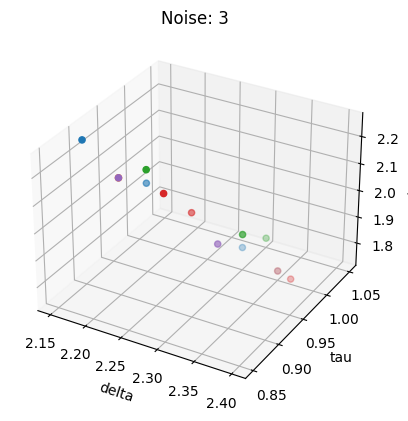

In [46]:
noise = 3
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

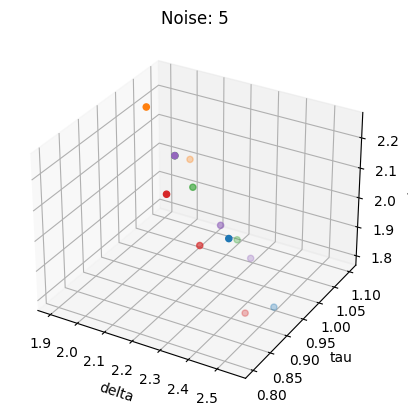

In [47]:
noise = 5
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

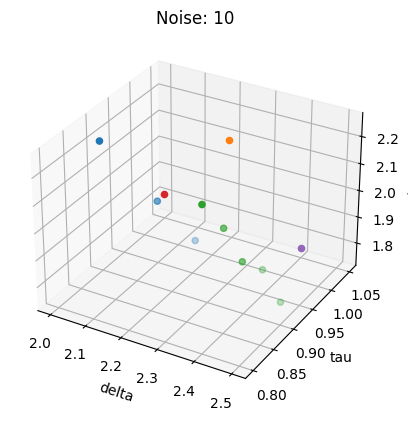

In [48]:
noise = 10
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

### Downsample with missing data

In [49]:
model = df['model_name'].unique()[1]
print(f"For Model '{model}'")
portion_df = df[df['model_name'] == model].drop(columns='model_name')
delta_unique_values = portion_df['delta'].unique()    
tau_unique_values = portion_df['tau'].unique()
alpha_unique_values = portion_df['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(portion_df['delta'].values, new_shape)
tau_pts = np.reshape(portion_df['tau'].values, new_shape)
alpha_pts = np.reshape(portion_df['alpha'].values, new_shape)

For Model 'downsample_without_nans_with_nans'


In [50]:
# Find local minima
columns = portion_df.columns.drop(['delta', 'tau', 'alpha'])
     
m = np.reshape(
    portion_df[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

In [51]:
local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
for noise in noise_range:
    columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
    local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
    for point in local_minima_with_given_noise:
        point_as_list = tuple(point.tolist())
        local_minima.append({
            'noise': noise,
            'iteration': columns[point[-1]].split('trial')[-1],
            'cost': m[point_as_list],
            'delta': delta_pts[point_as_list[:-1]],
            'tau': tau_pts[point_as_list[:-1]],
            'alpha': alpha_pts[point_as_list[:-1]]
        })

local_minima_by_noise = pd.DataFrame(local_minima)
local_minima_by_noise


noise iteration        cost               delta                 tau  \
0         1        34    0.976125  2.1500000000000012  0.9000000000000001   
1         1        86    0.980642  2.1500000000000012  0.9000000000000001   
2         1         1    1.008560  2.1500000000000012  0.9000000000000001   
3         1         2    1.034503  2.1500000000000012  0.9000000000000001   
4         1         3    1.021742  2.1500000000000012  0.9000000000000001   
...     ...       ...         ...                 ...                 ...   
2562     10        29   93.329265  2.6500000000000012  0.9000000000000001   
2563     10        59  100.337632  2.6500000000000012  0.9000000000000001   
2564     10        47  111.878139  2.7000000000000015                 0.8   
2565     10        74   96.083754  2.7000000000000015  0.9000000000000001   
2566     10        74   96.072120  2.7000000000000015  0.9500000000000002   

                   alpha  
0                    2.2  
1                    2.2  
2     2.2500000000000004  
3     2.2500000000000004  
4     2.2500000000000004  
...                  ...  
2562                1.75  
2563                 1.8  
2564  1.9000000000000001  
2565  1.9000000000000001  
2566                1.75  

[2567 rows x 6 columns]

In [52]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').describe()

Number of Local Minima                                         
                       count  mean       std  min  25%  50%  75%  max
noise                                                                
1                      100.0  3.22  0.578748  2.0  3.0  3.0  3.0  5.0
2                      100.0  3.12  0.537108  2.0  3.0  3.0  3.0  5.0
3                      100.0  2.91  0.712018  1.0  3.0  3.0  3.0  4.0
4                      100.0  2.69  0.825050  1.0  2.0  3.0  3.0  5.0
5                      100.0  2.63  0.906263  1.0  2.0  3.0  3.0  5.0
6                      100.0  2.44  1.085441  1.0  1.0  3.0  3.0  5.0
7                      100.0  2.24  0.965255  1.0  1.0  2.0  3.0  5.0
8                      100.0  2.26  1.040784  1.0  1.0  2.0  3.0  5.0
9                      100.0  2.17  1.015586  1.0  1.0  2.0  3.0  5.0
10                     100.0  1.99  0.999949  1.0  1.0  2.0  3.0  4.0

#### Local minima at edges

In [53]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [54]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [55]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

noise iteration        cost               delta   tau  \
1663      6        24   35.680322   2.450000000000001  0.75   
1784      7        82   49.726088   2.250000000000001  0.75   
1896      7        34   47.499071   2.450000000000001  0.75   
2071      8        71   63.965363  2.3500000000000014  0.75   
2090      8        71   63.959119  2.4000000000000012  0.75   
2124      8        65   69.252335  2.5000000000000013  0.75   
2145      8         4   78.245886  2.7000000000000015  0.75   
2320      9        49   82.918306  2.4000000000000012  0.75   
2321      9        34   81.727945  2.4000000000000012  0.75   
2347      9        55   82.687230  2.5000000000000013  0.75   
2348      9        72   86.834184  2.5000000000000013  0.75   
2355      9        55   82.683547  2.5500000000000016  0.75   
2367      9         0   83.392264   2.950000000000002  0.75   
2468     10        34   97.786081  2.3500000000000014  0.75   
2529     10        19  100.581125  2.5000000000000013  0.75   
2544     10        55  105.499468  2.5500000000000016  0.75   
2553     10         7   95.288447  2.6000000000000014  0.75   
2559     10        47  111.868199  2.6500000000000012  0.75   

                   alpha  
1663  2.2500000000000004  
1784  2.2500000000000004  
1896  2.2500000000000004  
2071  2.2500000000000004  
2090  2.1500000000000004  
2124  2.2500000000000004  
2145                 1.8  
2320                 2.2  
2321  2.2500000000000004  
2347  2.2500000000000004  
2348  2.2500000000000004  
2355  2.1500000000000004  
2367                1.75  
2468  2.2500000000000004  
2529  2.2500000000000004  
2544  2.2500000000000004  
2553  1.9500000000000002  
2559  2.1500000000000004

In [56]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [57]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

noise iteration        cost               delta                 tau  \
277       1        76    1.047136   2.300000000000001  1.0500000000000003   
281       1         3    1.025739  2.3500000000000014  1.0000000000000002   
282       1        16    0.834583  2.3500000000000014  1.0000000000000002   
283       1        22    1.007463  2.3500000000000014  1.0000000000000002   
284       1        27    0.952014  2.3500000000000014  1.0000000000000002   
...     ...       ...         ...                 ...                 ...   
2557     10        73  105.867804  2.6000000000000014  0.9500000000000002   
2558     10        79   96.393665  2.6000000000000014  0.9500000000000002   
2560     10         7   95.272011  2.6500000000000012                 0.8   
2562     10        29   93.329265  2.6500000000000012  0.9000000000000001   
2566     10        74   96.072120  2.7000000000000015  0.9500000000000002   

     alpha  
277   1.75  
281   1.75  
282   1.75  
283   1.75  
284   1.75  
...    ...  
2557  1.75  
2558  1.75  
2560  1.75  
2562  1.75  
2566  1.75  

[420 rows x 6 columns]

In [58]:
alpha_min.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

delta                                   tau                             \
      count unique                 top freq count unique                 top   
noise                                                                          
1        25      3  2.3500000000000014   22    25      2  1.0000000000000002   
10       58     17  2.4000000000000012   11    58     10  0.9500000000000002   
2        40      5  2.3500000000000014   23    40      3  1.0000000000000002   
3        38      6  2.3500000000000014   12    38      3  1.0000000000000002   
4        38      9   2.300000000000001   12    38      5  1.0000000000000002   
5        40      8   2.300000000000001    9    40      6  1.0000000000000002   
6        43     11   2.300000000000001    8    43      8  1.0000000000000002   
7        45     12   2.300000000000001    8    45      7  1.0000000000000002   
8        49     15  2.3500000000000014    8    49      9  1.1000000000000003   
9        44     15  2.3500000000000014    8    44      9  1.1000000000000003   

            
      freq  
noise       
1       24  
10      17  
2       30  
3       20  
4       14  
5       16  
6       14  
7       12  
8       13  
9        9

In [59]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

noise iteration        cost               delta                 tau  \
2         1         1    1.008560  2.1500000000000012  0.9000000000000001   
3         1         2    1.034503  2.1500000000000012  0.9000000000000001   
4         1         3    1.021742  2.1500000000000012  0.9000000000000001   
5         1         4    0.966659  2.1500000000000012  0.9000000000000001   
6         1        10    0.978117  2.1500000000000012  0.9000000000000001   
...     ...       ...         ...                 ...                 ...   
2519     10        67  107.915314   2.450000000000001  0.8500000000000001   
2529     10        19  100.581125  2.5000000000000013                0.75   
2544     10        55  105.499468  2.5500000000000016                0.75   
2546     10         8  102.067595  2.5500000000000016                 0.8   
2549     10        10   97.363605  2.5500000000000016  0.8500000000000001   

                   alpha  
2     2.2500000000000004  
3     2.2500000000000004  
4     2.2500000000000004  
5     2.2500000000000004  
6     2.2500000000000004  
...                  ...  
2519  2.2500000000000004  
2529  2.2500000000000004  
2544  2.2500000000000004  
2546  2.2500000000000004  
2549  2.2500000000000004  

[465 rows x 6 columns]

In [60]:
alpha_max.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

delta                                   tau                             \
      count unique                 top freq count unique                 top   
noise                                                                          
1        54      2  2.1500000000000012   49    54      1  0.9000000000000001   
10       41     19  2.3500000000000014    5    41      8  0.8500000000000001   
2        46      6  2.1500000000000012   25    46      3  0.9000000000000001   
3        44      9  2.1500000000000012   16    44      4  0.9000000000000001   
4        46      9  2.1500000000000012   11    46      4  0.9000000000000001   
5        45     11  2.1500000000000012   10    45      5  0.9000000000000001   
6        49     14   2.200000000000001   10    49      7  0.9000000000000001   
7        48     13   2.200000000000001    7    48      6  0.8500000000000001   
8        45     19  2.0500000000000007    7    45     10  0.9000000000000001   
9        47     15   2.200000000000001    8    47      8  0.8500000000000001   

            
      freq  
noise       
1       54  
10      13  
2       39  
3       30  
4       25  
5       20  
6       15  
7       13  
8       10  
9       15

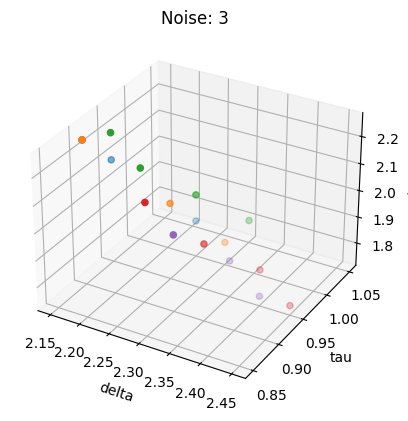

In [61]:
noise = 3
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

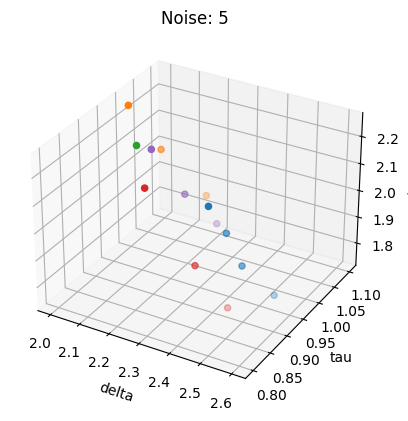

In [62]:
noise = 5
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

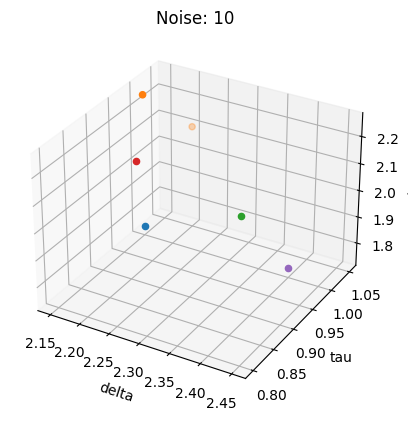

In [63]:
noise = 10
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()